In [11]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pymc.sampling_jax
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_circles
from scipy.special import expit

plt.style.use("bmh")
plt.rcParams["figure.figsize"] = [12, 6]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<AxesSubplot:>

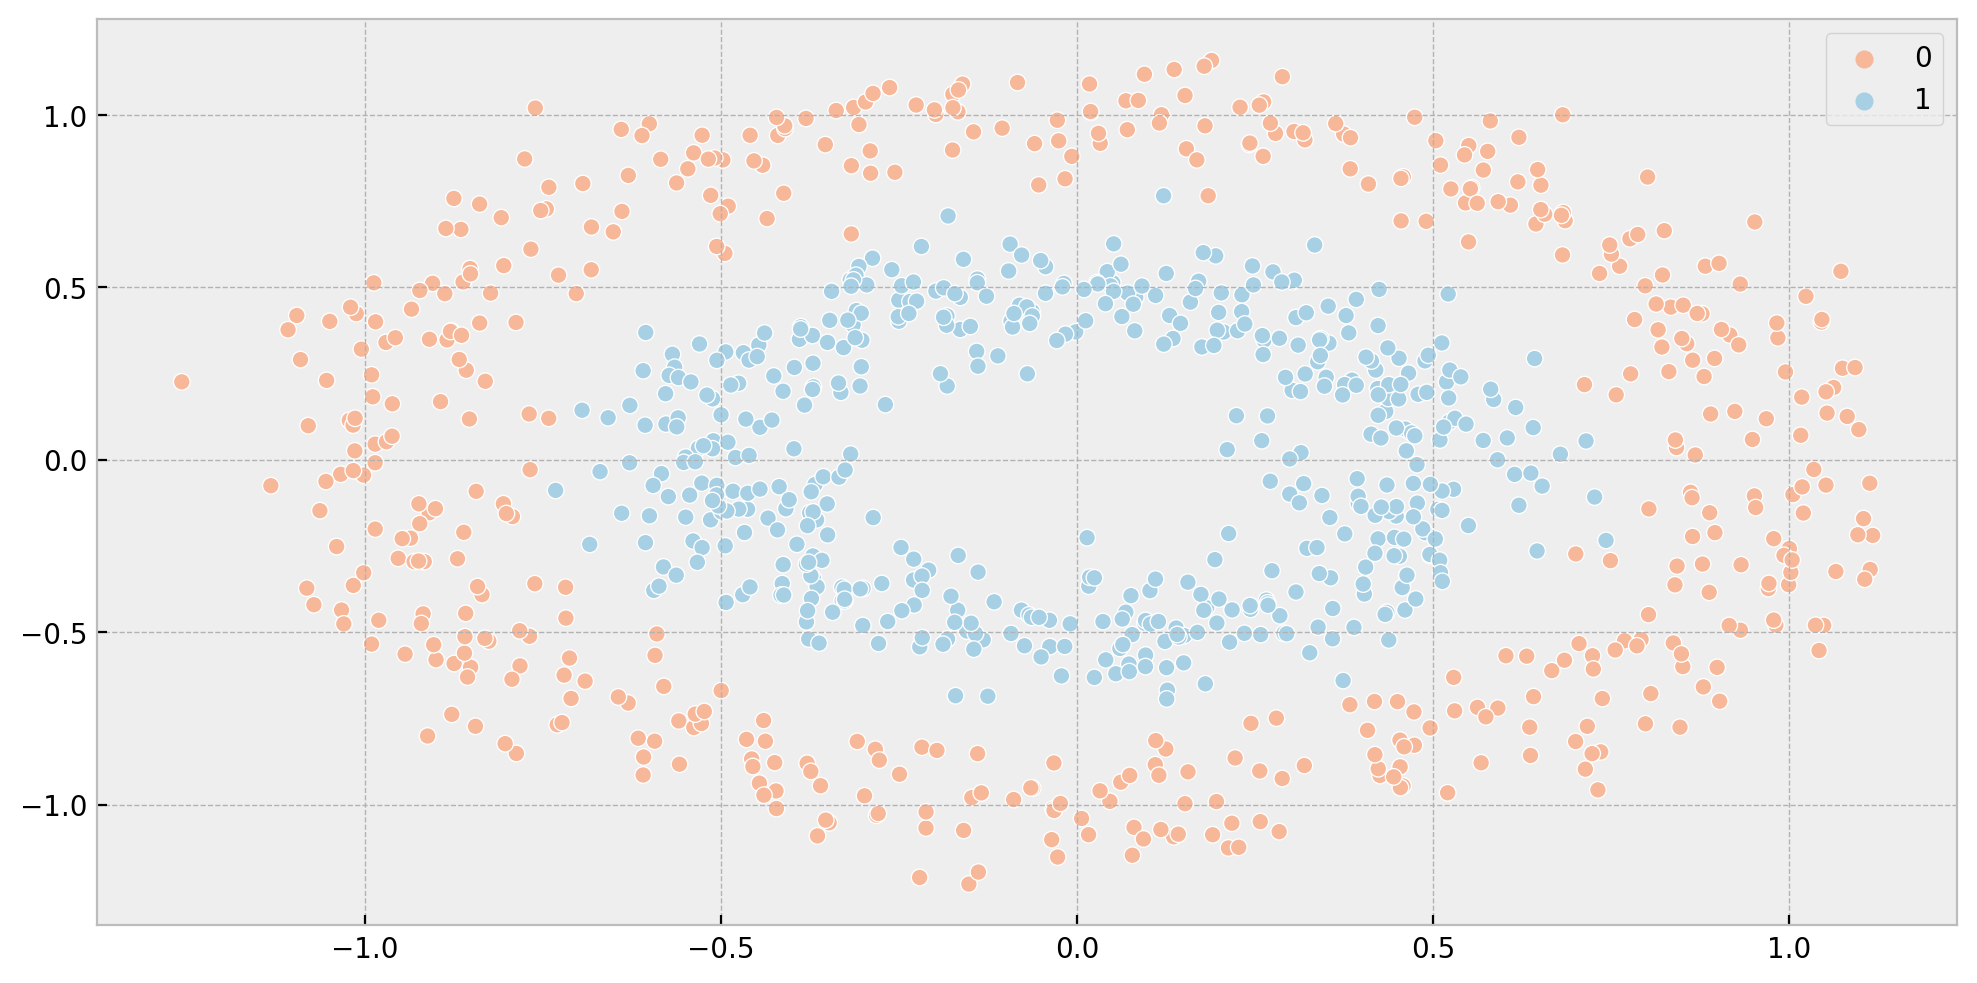

In [12]:
circles = make_circles(n_samples=1000, noise=0.1, factor=0.5, random_state=RANDOM_SEED)
sns.scatterplot(x=circles[0][:, 0], y=circles[0][:, 1], hue=circles[1], palette="RdBu")

<AxesSubplot:>

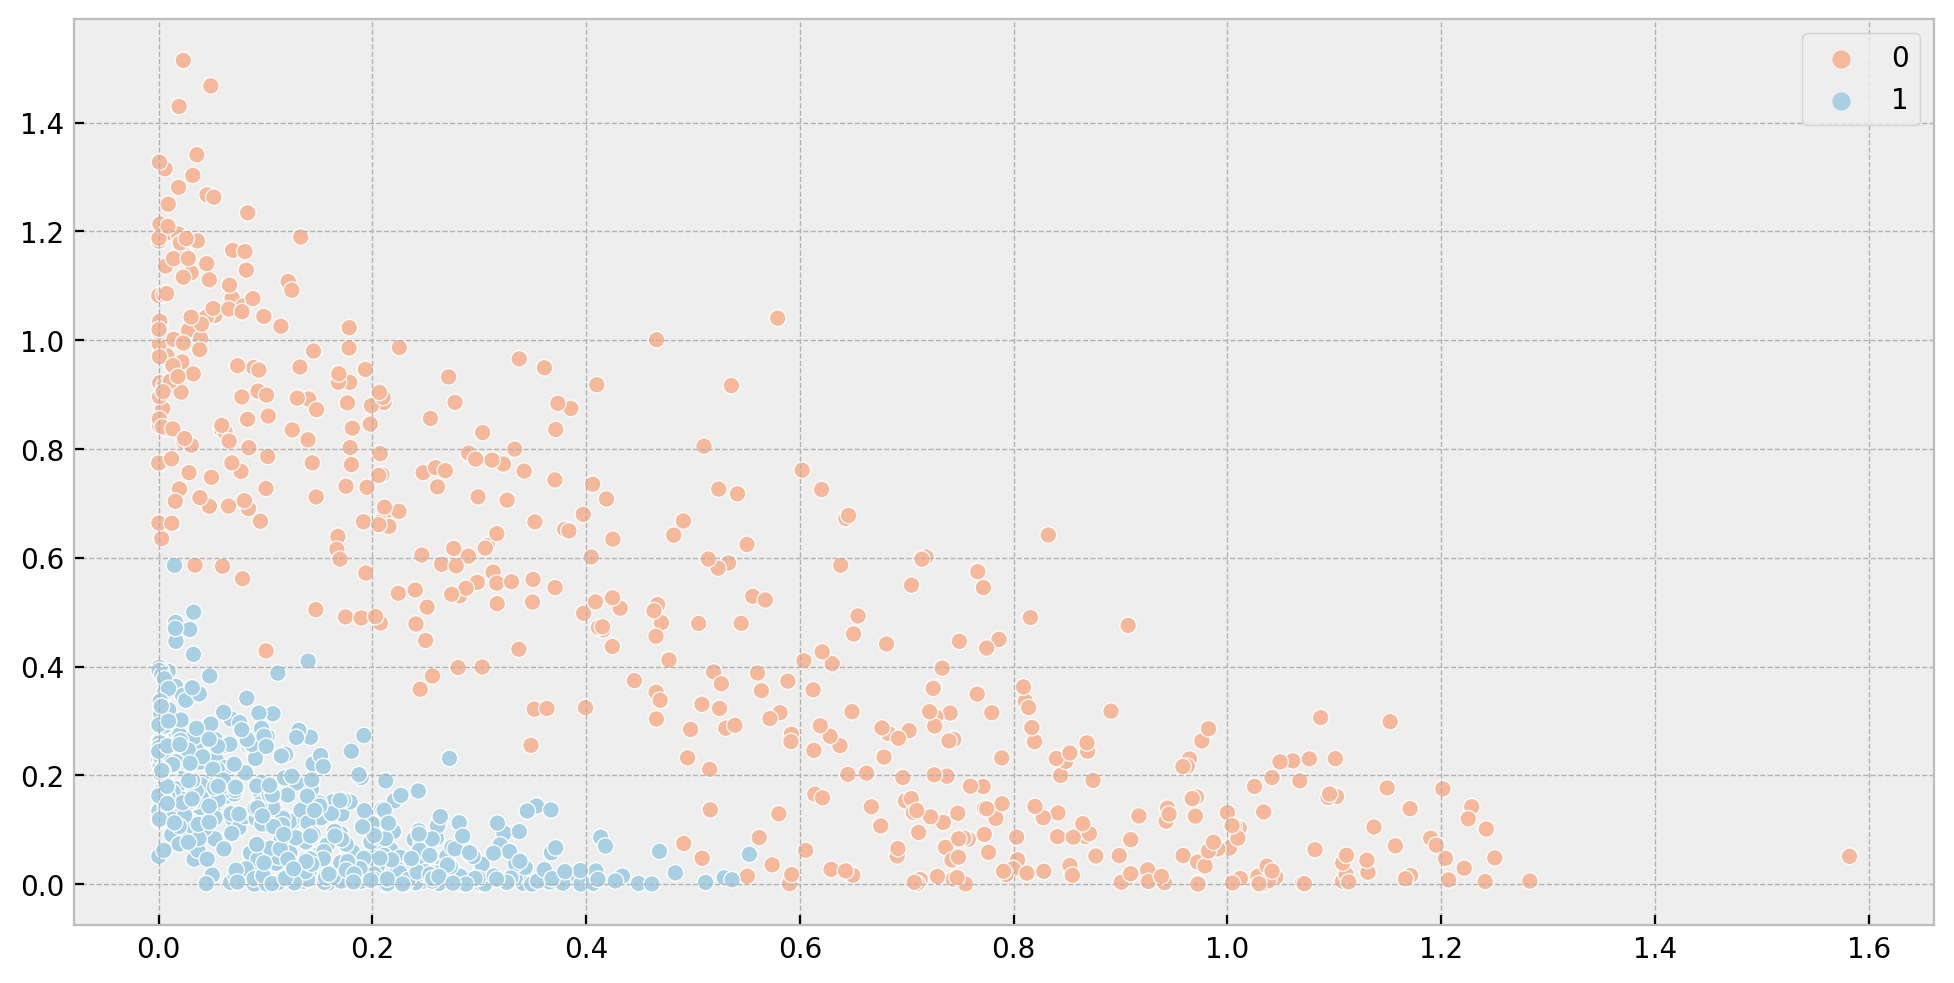

In [13]:
sns.scatterplot(x=circles[0][:, 0]**2, y=circles[0][:, 1]**2, hue=circles[1], palette="RdBu")

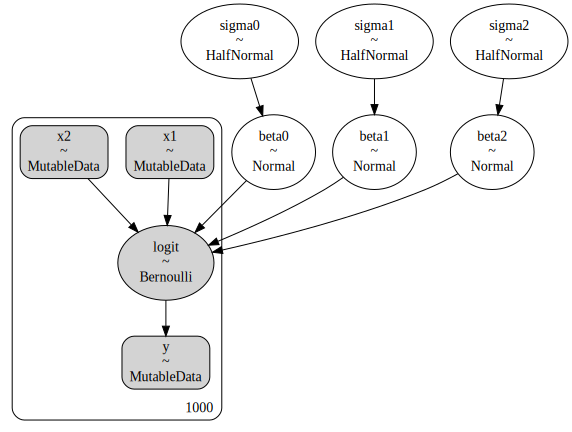

In [14]:
with pm.Model() as model:
    # Data
    x1 = pm.MutableData("x1", circles[0][:, 0])
    x2 = pm.MutableData("x2", circles[0][:, 1])

    y = pm.MutableData("y", circles[1])

    # Priors
    sigma0 = pm.HalfNormal("sigma0", 1)
    sigma1 = pm.HalfNormal("sigma1", 1)
    sigma2 = pm.HalfNormal("sigma2", 1)

    beta0 = pm.Normal("beta0", mu=0, sigma=sigma0)
    beta1 = pm.Normal("beta1", mu=-0.1, sigma=sigma1)
    beta2 = pm.Normal("beta2", mu=-0.1, sigma=sigma2)

    likelihood =  pm.invlogit(beta0 + beta1 * x1**2 + beta2 * x2**2)
    logit = pm.Bernoulli("logit", likelihood, observed=y)

pm.model_to_graphviz(model)


In [15]:
with model:
    priors = pm.sample_prior_predictive(samples=1000)


print(y.mean(), priors.prior_predictive.logit.mean().values)

mean 0.492426


In [16]:
with model:
    trace = pm.sample(6000, tune=1000, target_accept=0.95, cores=-1, chains=4)

Auto-assigning NUTS sampler...
INFO:pymc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc:Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
INFO:pymc:Sequential sampling (4 chains in 1 job)
NUTS: [sigma0, sigma1, sigma2, beta0, beta1, beta2]
INFO:pymc:NUTS: [sigma0, sigma1, sigma2, beta0, beta1, beta2]


Sampling 4 chains for 1_000 tune and 6_000 draw iterations (4_000 + 24_000 draws total) took 59 seconds.
INFO:pymc:Sampling 4 chains for 1_000 tune and 6_000 draw iterations (4_000 + 24_000 draws total) took 59 seconds.


array([[<AxesSubplot:title={'center':'beta0'}>,
        <AxesSubplot:title={'center':'beta0'}>],
       [<AxesSubplot:title={'center':'beta1'}>,
        <AxesSubplot:title={'center':'beta1'}>],
       [<AxesSubplot:title={'center':'beta2'}>,
        <AxesSubplot:title={'center':'beta2'}>]], dtype=object)

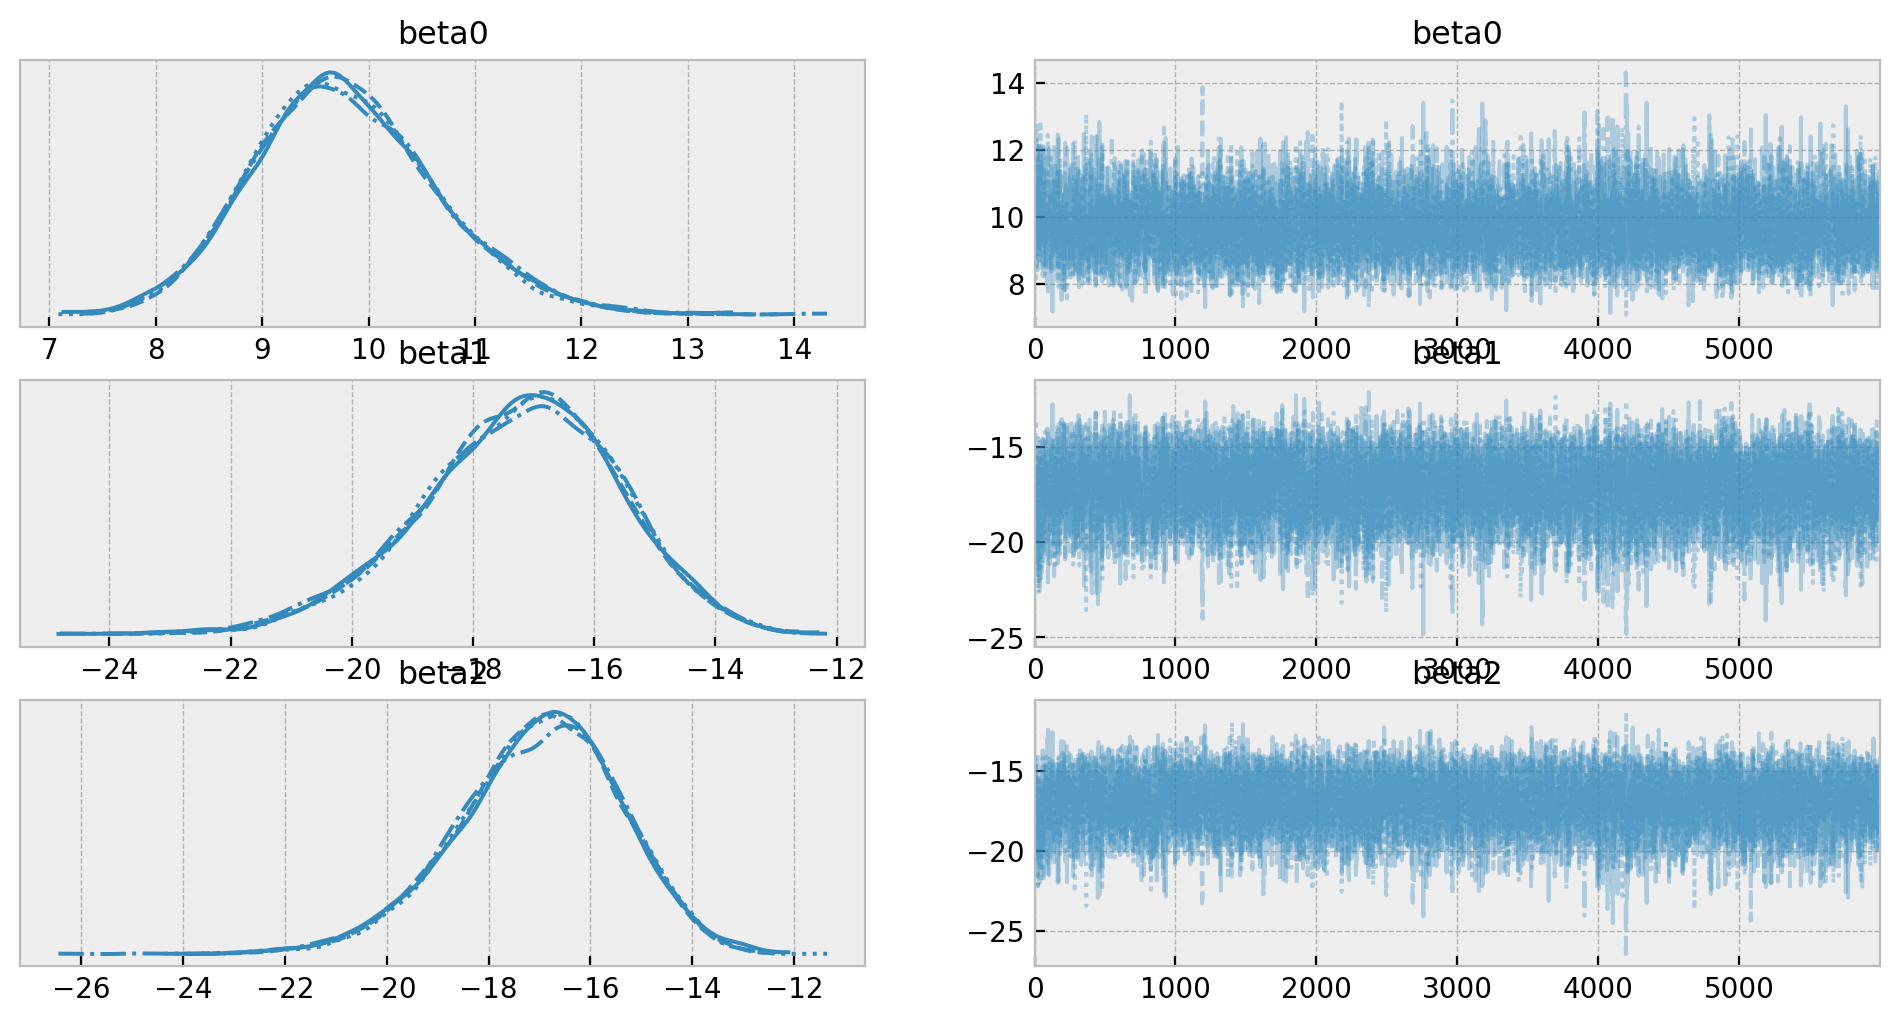

In [17]:
pm.plot_trace(trace, var_names=["beta0", "beta1", "beta2"])

In [18]:
with model:
    posterior = pm.sample_posterior_predictive(trace)

In [19]:
predictions = posterior.posterior_predictive.logit.mean(axis=0).mean(axis=0)
miss = (predictions.round() != circles[1])
predictions_correct = 1 - miss.mean()
print(predictions_correct)
predictions = np.round(predictions.values * 10) / 10
ddata = pd.DataFrame({"x1": x1.get_value(), "x2": x2.get_value(), "likelihood": predictions})


<xarray.DataArray 'logit' ()>
array(0.994)


<AxesSubplot:>

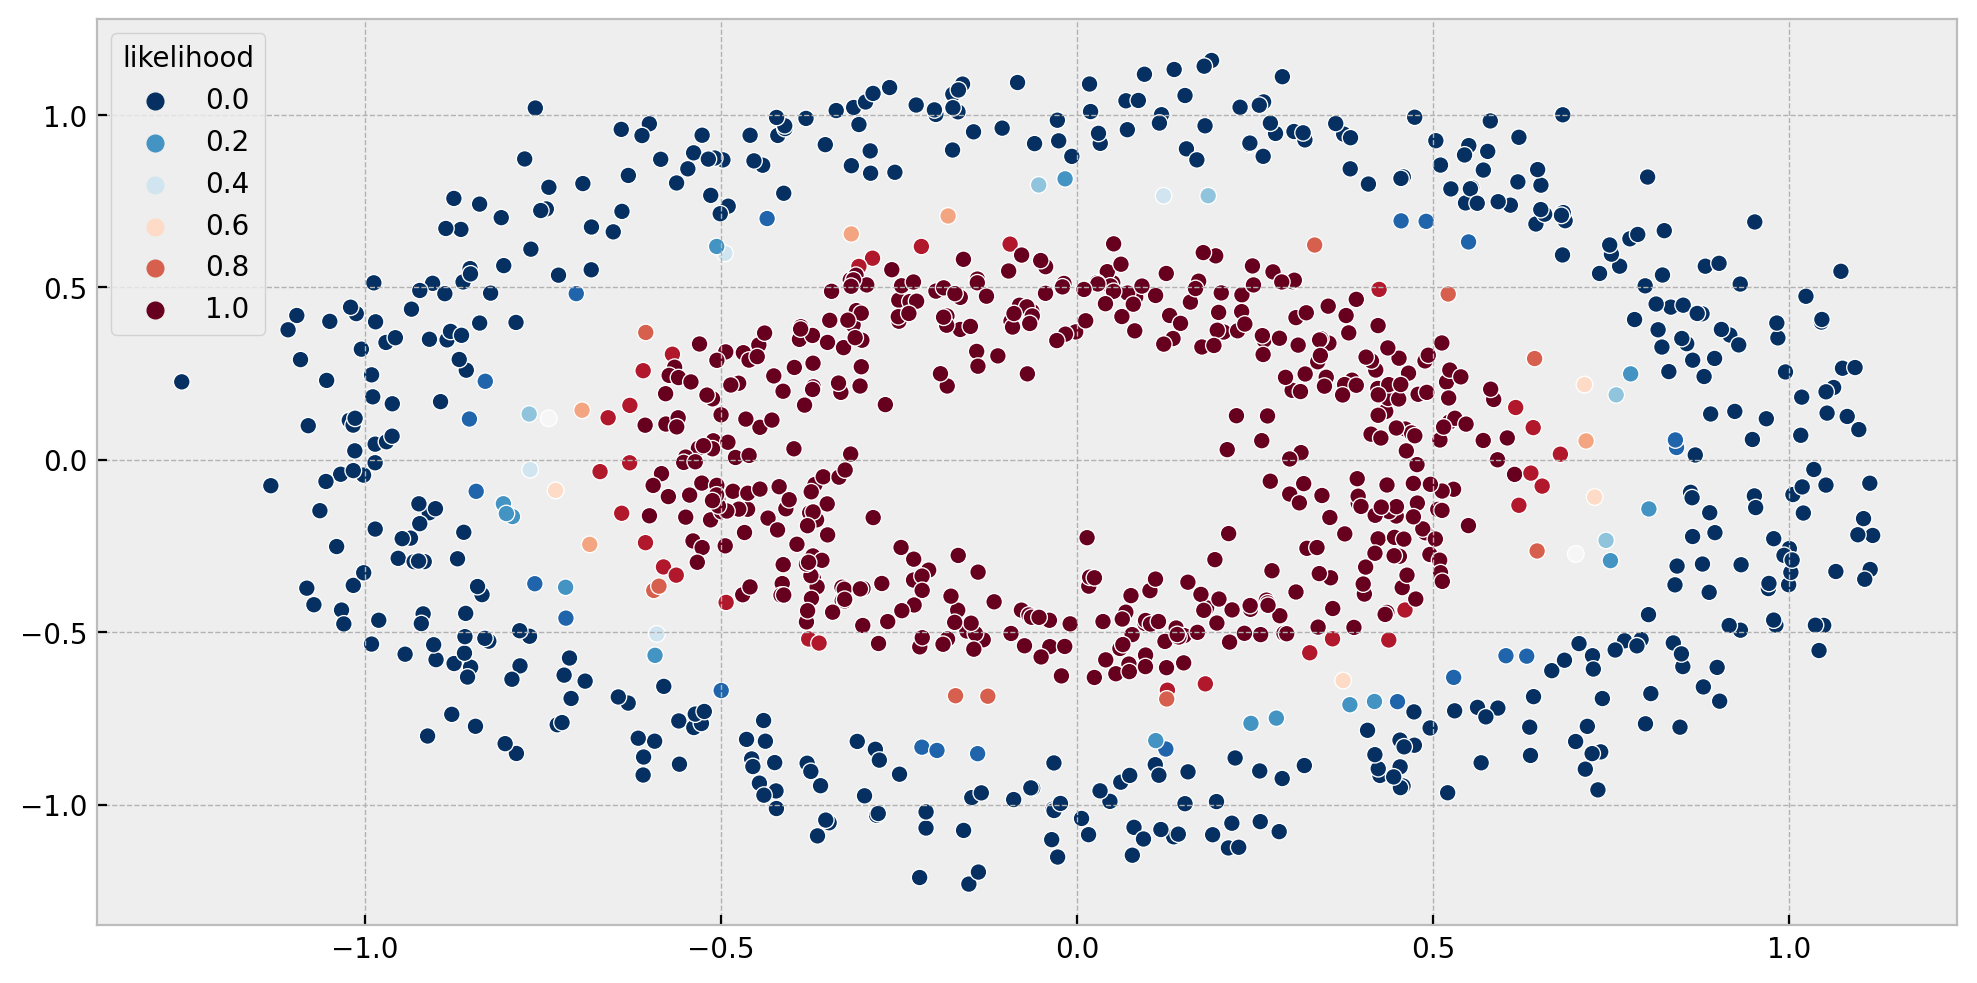

In [20]:
sns.scatterplot(data=ddata, x=circles[0][:, 0], y=circles[0][:, 1], hue="likelihood", palette="RdBu_r")